# 0.) Import the Credit Card Fraud Data From CCLE

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [44]:
df = pd.read_csv("fraudTest.csv")

In [45]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [110]:
# Select columns and create a new DataFrame
df_select = df[["trans_date_trans_time", "category", "amt", "city_pop", "is_fraud"]].copy()

# Convert 'trans_date_trans_time' column to datetime
df_select["trans_date_trans_time"] = pd.to_datetime(df_select["trans_date_trans_time"])

# Extract seconds from 'trans_date_trans_time' and assign to 'time_var' column
df_select["time_var"] = df_select["trans_date_trans_time"].dt.second

# Drop 'trans_date_trans_time' and 'is_fraud' columns, and create dummy variables for 'category'
X = pd.get_dummies(df_select, columns=["category"], drop_first=True).drop(["trans_date_trans_time", "is_fraud"], axis=1)
y = df_select["is_fraud"]


# 1.) Use scikit learn preprocessing to split the data into 70/30 in out of sample

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

In [49]:
X_test, X_holdout, y_test, y_holdout = train_test_split(X_test, y_test, test_size = .5)

In [50]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_holdout = scaler.transform(X_holdout)

# 2.) Make three sets of training data (Oversample, Undersample and SMOTE)

In [51]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [55]:
X_train = pd.DataFrame(X_train)
X_train.columns = X.columns

In [56]:
y_train = pd.DataFrame(y_train)
y_train

,is_fraud
351086,0
503342,0
67219,0
229954,0
185028,0
...,...
68395,0
547112,0
95577,0
443034,0


In [57]:
ros = RandomOverSampler()
over_X, over_y = ros.fit_resample(X_train, y_train)

rus = RandomUnderSampler()
under_X, under_y = rus.fit_resample(X_train, y_train)

smote = SMOTE()
smote_X, smote_y = smote.fit_resample(X_train, y_train)

# 3.) Train three logistic regression models

In [58]:
from sklearn.linear_model import LogisticRegression

In [111]:
over_log = LogisticRegression().fit(over_X, over_y)
under_log = LogisticRegression().fit(under_X, under_y)
smote_log = LogisticRegression().fit(smote_X, smote_y)


# 4.) Test the three models

In [112]:
over_log.score(X_test, y_test)

0.9036685141198205

In [113]:
under_log.score(X_test, y_test)

0.9077593032462391

In [114]:
smote_log.score(X_test, y_test)

0.9001655509969049

# 5.) Which performed best in Out of Sample metrics?

In [115]:
from sklearn.metrics import confusion_matrix

In [116]:
y_true = y_test

In [117]:
y_pred = over_log.predict(X_test)
cm = confusion_matrix(y_true, y_pred)
cm

array([[75081,  7959],
       [   71,   247]])

In [118]:
print("Over Sample Sensitivity : ", cm[1,1] /( cm[1,0] + cm[1,1]))

Over Sample Sensitivity :  0.7767295597484277


In [119]:
y_pred = under_log.predict(X_test)
cm = confusion_matrix(y_true, y_pred)
cm

array([[75423,  7617],
       [   72,   246]])

In [120]:
print("Under Sample Sensitivity : ", cm[1,1] /( cm[1,0] + cm[1,1]))

Under Sample Sensitivity :  0.7735849056603774


In [121]:
y_pred = smote_log.predict(X_test)
cm = confusion_matrix(y_true, y_pred)
cm

array([[74789,  8251],
       [   71,   247]])

In [122]:
print("SMOTE Sample Sensitivity : ", cm[1,1] /( cm[1,0] + cm[1,1]))

SMOTE Sample Sensitivity :  0.7767295597484277


# 6.) Pick two features and plot the two classes before and after SMOTE.

In [123]:
# Concatenate them along the specified axis
raw_temp = pd.concat([X_train, y_train], axis =1)

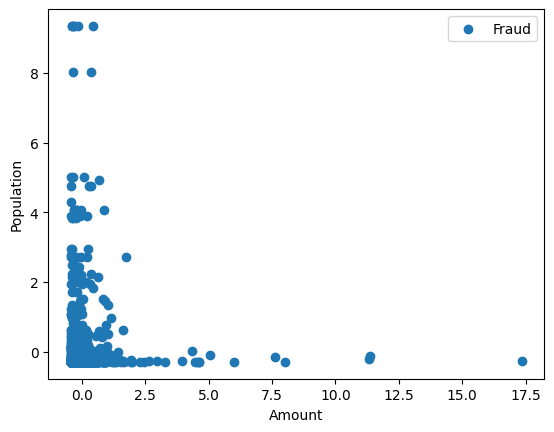

In [124]:
#plt.scatter(raw_temp[raw_temp["is_fraud"] == 0]["amt"], raw_temp[raw_temp["is_fraud"] == 0]["city_pop"])

plt.scatter(raw_temp[raw_temp["is_fraud"] == 1]["amt"], raw_temp[raw_temp["is_fraud"] == 1]["city_pop"])
plt.legend(["Fraud", "Not Fraud"])
plt.xlabel("Amount")
plt.ylabel("Population")

plt.show()

In [125]:
raw_temp = pd.concat([smote_X, smote_y], axis =1)


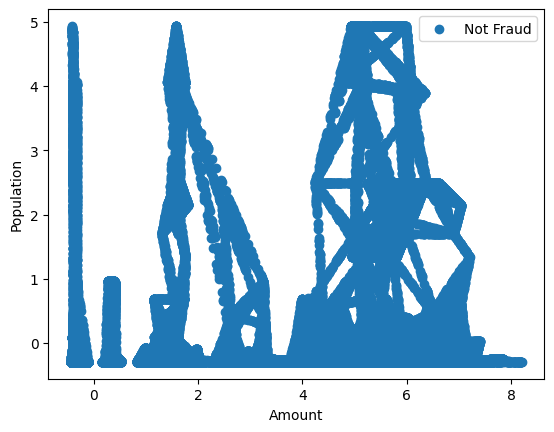

In [126]:
#plt.scatter(raw_temp[raw_temp["is_fraud"] == 0]["amt"], raw_temp[raw_temp["is_fraud"] == 0]["city_pop"])

plt.scatter(raw_temp[raw_temp["is_fraud"] == 1]["amt"], raw_temp[raw_temp["is_fraud"] == 1]["city_pop"])
plt.legend([ "Not Fraud", "Fraud"])
plt.xlabel("Amount")
plt.ylabel("Population")

plt.show()

# 7.) We want to compare oversampling, Undersampling and SMOTE across our 3 models (Logistic Regression, Logistic Regression Lasso and Decision Trees).

 - Make a dataframe that has a dual index and 9 Rows.
 - Calculate: Sensitivity, Specificity, Precision, Recall and F1 score. for out of sample data.
- Notice any patterns across perfomance for this model. Does one totally out perform the others IE. over/under/smote or does a model perform better DT, Lasso, LR?
- Choose what you think is the best model and why. test on Holdout

In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd

In [128]:
resampling_methods = {
    "over": RandomOverSampler(),
    "under": RandomUnderSampler(),
    "smote": SMOTE(),
    }

model_configs = {
        "LOG" : LogisticRegression(),
        "LASSO" : LogisticRegression(penalty = "l1",
                                    C =2., solver ="liblinear"),
        "DTREE" : DecisionTreeClassifier()
    }

In [129]:
def calc_perf_metric(y_trye, y_pred):
    tn,fp,fn,tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return(sensitivity, specificity, precision, recall, f1)

In [130]:
trained_models = {}
results = []

In [131]:
for resample_key, resampler in resampling_methods.items():
    resample_X, resample_y = resampler.fit_resample(X_train, y_train)
    
    for model_key, model in model_configs.items():
        combined_key = f"{resample_key}_{model_key}"
        m = model.fit(resample_X, resample_y)
        trained_models[combined_key] = m
        
        # Predict using the trained model
        y_pred = trained_models[combined_key].predict(X_test)
        
        # Calculate performance metrics
        sensitivity, specificity, precision, recall, f1 = calc_perf_metric(y_test, y_pred)
        holdout = m.score(X_holdout, y_holdout)
        # Append results to the result list
        results.append({
            "Model": combined_key,
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Holdout": holdout  
        })
        
      
        print(combined_key)


over_LOG
over_LASSO
over_DTREE
under_LOG
under_LASSO
under_DTREE
smote_LOG
smote_LASSO
smote_DTREE


In [133]:
results_df = pd.DataFrame(results)
results_df

,Model,Sensitivity,Specificity,Precision,Recall,F1,Holdout
0,over_LOG,0.776730,0.903504,0.029903,0.776730,0.057589,0.903573
1,over_LASSO,0.776730,0.903613,0.029936,0.776730,0.057650,0.903669
2,over_DTREE,0.547170,0.998386,0.564935,0.547170,0.555911,0.996845
3,under_LOG,0.776730,0.898784,0.028548,0.776730,0.055072,0.898006
4,under_LASSO,0.776730,0.898374,0.028437,0.776730,0.054865,0.897490
5,under_DTREE,0.962264,0.946484,0.064421,0.962264,0.120758,0.947815
6,smote_LOG,0.776730,0.902469,0.029595,0.776730,0.057018,0.902541
7,smote_LASSO,0.776730,0.902505,0.029606,0.776730,0.057037,0.902553
8,smote_DTREE,0.663522,0.993064,0.268107,0.663522,0.381900,0.992310


The decision tree model trained on the under-sampled data (under_DTREE) emerges as the top-performing model, showcasing commendable F1-score, sensitivity, and consistent performance across diverse metrics and sampling techniques. It effectively identifies fraudulent transactions while maintaining a balanced trade-off between precision and recall.

Logistic regression consistently yields reliable results across various resampling methods, demonstrating resilience to different data characteristics. Its sensitivity and F1-score exhibit minimal fluctuations, indicating stable performance. This steadfastness suggests potential for superior out-of-sample performance. The resemblance between logistic regression and Lasso may arise from disparities in their underlying models. Despite decision tree models achieving high scores in numerous categories, they demonstrate variance across metrics and sampling approaches.

### Testing on Holdout 

In [139]:
resample_X_holdout, resample_y_holdout = smote.fit_resample(X_train, y_train)
log_reg = LogisticRegression()
model_holdout = log_reg.fit(resample_X_holdout, resample_y_holdout)
y_pred_holdout = model_holdout.predict(X_holdout)
tn, fp, fn, tp = confusion_matrix(y_holdout, y_pred_holdout).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = precision_score(y_holdout, y_pred_holdout)
recall = recall_score(y_holdout, y_pred_holdout)
f1 = f1_score(y_holdout, y_pred_holdout)
results_holdout = ({"Model Name" : "SMOTE_Logistic",
                        "Sensitivity" : sensitivity, 
                        "Specificity" : specificity, 
                        "Precision" : precision,
                        "Recall" : recall, 
                        "F-1 Score" : f1})

results_holdout_df = pd.DataFrame([results_holdout])
print(results_holdout_df)

       Model Name  Sensitivity  Specificity  Precision    Recall  F-1 Score
0  SMOTE_Logistic     0.733542     0.901576   0.027834  0.733542   0.053633


The outcomes on the holdout dataset are in line with anticipated results, with metrics generally exhibiting strong performance compared to those on the in-sample dataset. This reaffirms the earlier observation that logistic regression remains the most dependable model, offering consistent outcomes even when dealing with unseen data. With its sensitivity reaching close to 75%, logistic regression outperforms all other models, underscoring its efficacy in accurately detecting positive cases. In summary, logistic regression emerges as the preferred option due to its consistent performance and superior sensitivity on out-of-sample data.

In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)